# Importing and Loading

### Importing relevant libs

In [24]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
%matplotlib inline
sns.set()

### Reading dataset

In [295]:
data_store = pd.read_csv('./data/store.csv') 
data_train = pd.read_csv('./data/train.csv', parse_dates = True, low_memory = False, index_col = 'Date')
data_test = pd.read_csv('./data/test.csv', parse_dates = True, low_memory = False, index_col = 'Date')

# Dataset Exploration

## Knowing the data

### Data exploration pipeline

In [121]:
from IPython.display import display

def print_info(df):
    '''print a concise summary of a DataFrame
    Parameters:
        df (dataframe): a pandas dataframe object 
    '''
    print('\nDataframe summary')
    display(df.info())

def print_head(df):
    '''print out the first 5 rows of a dataframe
    Parameters:
        df (dataframe): a pandas dataframe object
    '''
    print('\nFirst 5 rows')
    display(df.head())
    
def print_shape(df):
    '''print out shape of a dataframe
    Parameters: 
        df (dataframe): a pandas dataframe object
    '''
    
    print('\nShape of the dataset')
    display(df.shape)
    
def print_missing_values(df):
    '''print out count of  missing value of a dataframe
    Parameters: 
        df (dataframe): a pandas dataframe object
    '''
    
    print('\nMissing values count')
    display(df.isna().sum())
    
def explore_df(df):
    '''print out shape, head, info, missing value count of a dataframe
    Parameters: 
        df (dataframe): a pandas dataframe object
    '''
    
    print_shape(df)
    print_head(df)
    print_info(df)
    print_missing_values(df)

In [ ]:
explore_df(data_store)

### Training dataset exploration

In [ ]:
explore_df(data_train)

### Testing dataset exploration

In [ ]:
explore_df(data_test)

### Missing value treatment

In [61]:
data_test['Open'] = data_test['Open'].fillna(data_test['Open'].mode())

In [299]:
data_store[data_store.CompetitionDistance.isna()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [172]:
data_store['CompetitionDistance'].fillna(data_store['CompetitionDistance'].median(), inplace = True)

In [173]:
data_store.fillna(0, inplace = True)

In [282]:
data_train_clean = data_train_clean[~((data_train_clean.Open == 0) & (data_train_clean.Sales == 0))]

### Outlier treating pipeline

In [124]:
from scipy.stats import zscore

def z_score_outlier_treatment(df, unvarient=True):
    z_scores = zscore(df)
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3) if unvarient \
    else (abs_z_scores < 3).all(axis=1)
    return filtered_entries

def iqr_outlier_treatment(df):
    Q1=df.quantile(0.25)
    Q3=df.quantile(0.75)
    IQR=Q3-Q1
    Lower_Whisker = Q1-1.5*IQR
    Upper_Whisker = Q3+1.5*IQR
    return (df < Upper_Whisker)

def treat_outlier(df, dataset, method='z-score', unvarient=True):
    
    if(unvarient):
        
        if (method == 'z-score'):
            filtered_entries = z_score_outlier_treatment(df, unvarient) 
        elif (method == 'iqr'):
            filtered_entries = iqr_outlier_treatment(df)
    else:
        filtered_entries = z_score_outlier_treatment(df, unvarient) 
    
    return dataset[filtered_entries].copy()

Detecting outliners

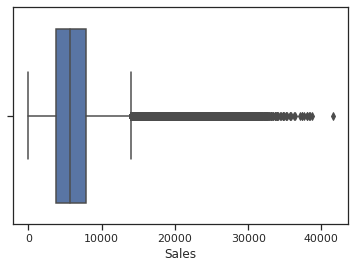

In [280]:
sns.boxplot(data_train.Sales)

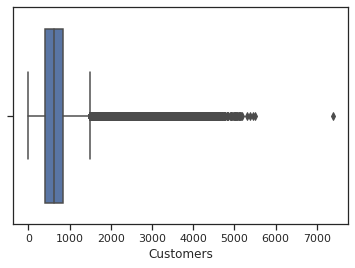

In [281]:
sns.boxplot(data_train.Customers)

Treating outliers on training data

In [177]:
data_clean_sales = treat_outlier(data_train.Sales, data_train, method='iqr')
data_train_clean = treat_outlier(data_clean_sales.Customers, data_clean_sales, method='iqr')
data_train_clean.shape

(967874, 8)

### Seasonality analysis of training set

In [207]:
# data extraction
data_train_clean['Year'] = data_train_clean.index.year
data_train_clean['Month'] = data_train_clean.index.month
data_train_clean['Day'] = data_train_clean.index.day
data_train_clean['WeekOfYear'] = data_train_clean.index.weekofyear
data_train_clean['DayOfWeek'] = data_train_clean.index.dayofweek

# adding new variable
data_train_clean['SalePerCustomer'] = data_train_clean['Sales']/data_train_clean['Customers']
data_train_clean['SalePerCustomer'].describe()

count    795005.000000
mean          9.575309
std           2.115504
min           0.000000
25%           7.989940
50%           9.336761
75%          10.947165
max          51.694444
Name: SalePerCustomer, dtype: float64

### Joining store and train datasets

In [210]:
data_train_store = pd.merge(data_train_clean, data_store, how = 'inner', on = 'Store')
data_train_store.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,4,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,3,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,2,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,1,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,0,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


### By store type

In [134]:
data_train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,428222.0,6381.755491,2425.186883,0.0,4592.0,6075.0,7903.0,14049.0
b,5158.0,5777.087437,1886.744114,0.0,4422.0,5606.5,7047.5,12470.0
c,106854.0,6514.357946,2261.597872,0.0,4830.0,6237.0,7957.0,14049.0
d,254823.0,6673.712357,2254.805596,0.0,5029.0,6350.0,8022.0,14048.0


In [136]:
data_train_store.groupby('StoreType')['Customers', 'Sales'].sum()

/home/ns/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,Customers,Sales
StoreType,,
a,310897004,2732808100
b,5475371,29798217
c,81877557,696085204
d,152239985,1700615404


/home/ns/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


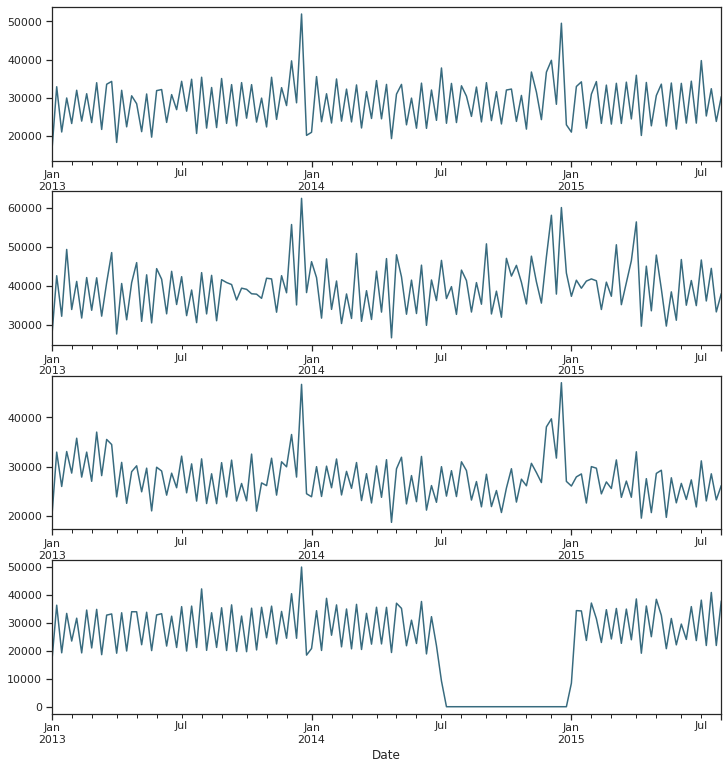

In [221]:
data_train_clean['Sales'] = data_train_clean['Sales'] * 1.0

# store types
sales_a = data_train_clean[data_train_clean.Store == 2]['Sales']
sales_b = data_train_clean[data_train_clean.Store == 85]['Sales'].sort_index(ascending = True) # solve the reverse order
sales_c = data_train_clean[data_train_clean.Store == 1]['Sales']
sales_d = data_train_clean[data_train_clean.Store == 13]['Sales']

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# store types
sales_a.resample('W').sum().plot(color = c, ax = ax1)
sales_b.resample('W').sum().plot(color = c, ax = ax2)
sales_c.resample('W').sum().plot(color = c, ax = ax3)
sales_d.resample('W').sum().plot(color = c, ax = ax4)

### Befor, after, during

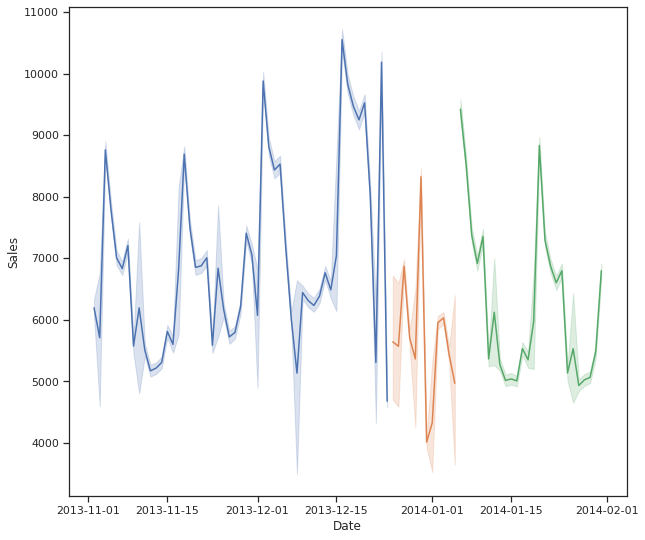

In [236]:
before_xmas = data_train_clean[(data_train_clean.index > '2013-11-01') & (data_train_clean.index < '2013-12-25') ].Sales
during_xmas = data_train_clean[(data_train_clean.index >= '2013-12-25') & (data_train_clean.index <= '2014-01-05') ].Sales
after_xmas = data_train_clean[(data_train_clean.index > '2014-01-05') & (data_train_clean.index < '2014-02-01') ].Sales

plt.subplots(figsize = (10, 9))

sns.lineplot(x = before_xmas.index, y = before_xmas)
sns.lineplot(x = during_xmas.index, y = during_xmas)
sns.lineplot(x = after_xmas.index, y = after_xmas)

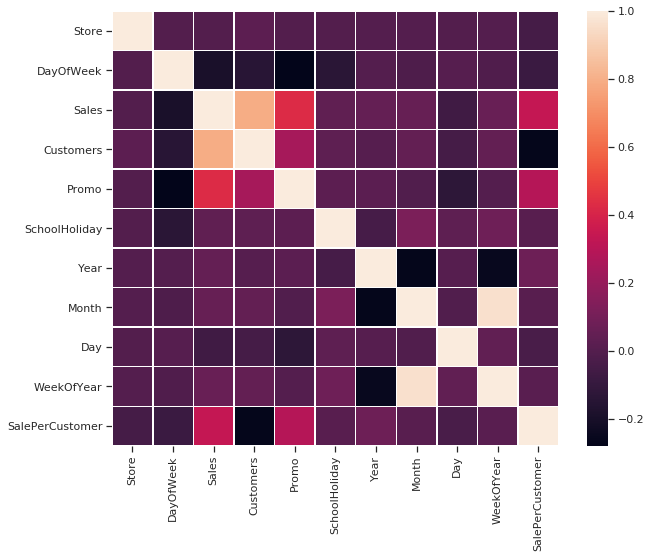

In [294]:
corr = data_train_clean.drop('Open', axis=1).corr()

plt.subplots(figsize = (10, 8))

sns.heatmap(corr, linewidths = .5)      
plt.show()

/home/ns/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


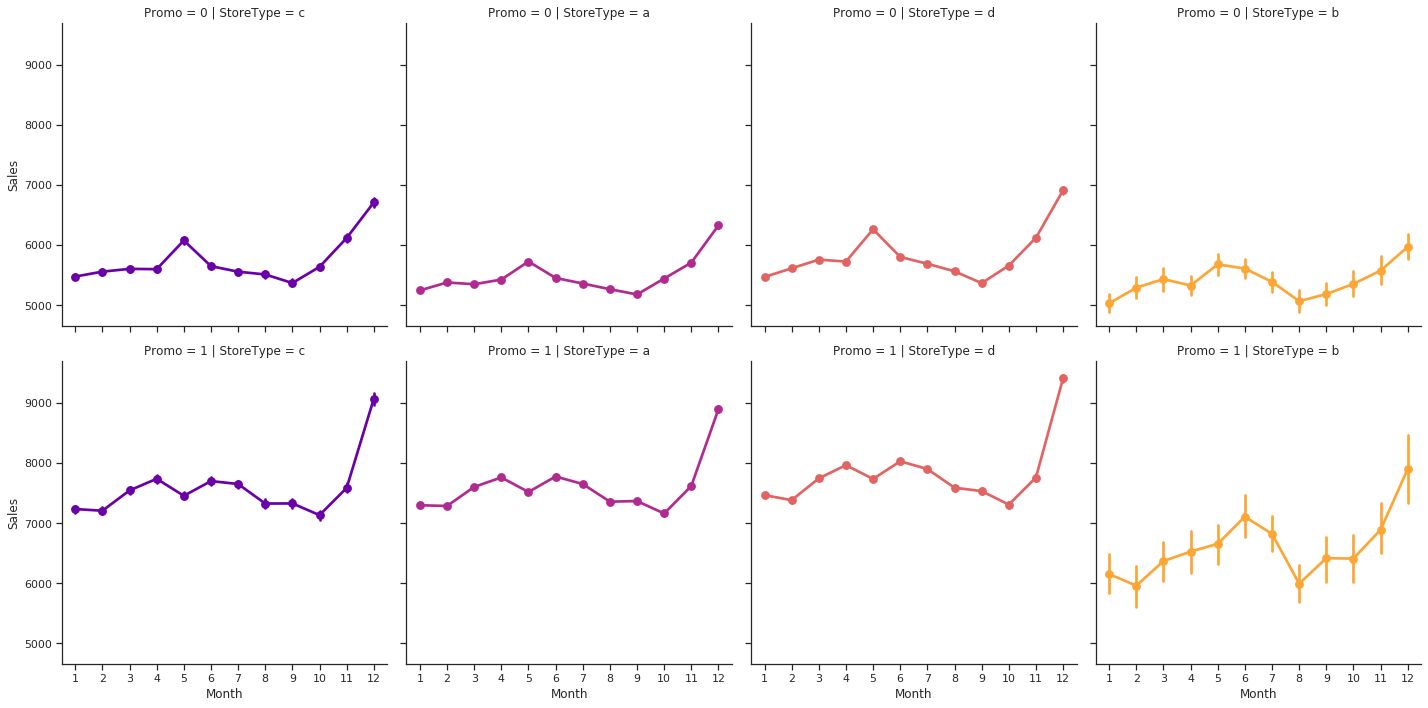

In [259]:
# sns.factorplot(data = data_train_store, x = 'Month', y = 'Sales', col='Promo', hue='Promo')
sns.factorplot(data = data_train_store, x = 'Month', y = "Sales", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c) 

/home/ns/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


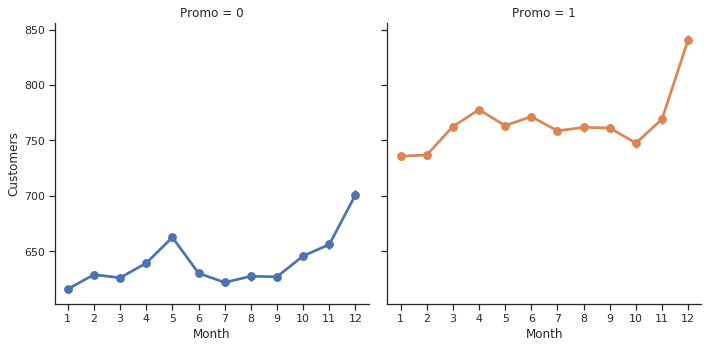

In [255]:
sns.factorplot(data = data_train_clean, x = 'Month', y = 'Customers', col='Promo', hue='Promo')

/home/ns/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


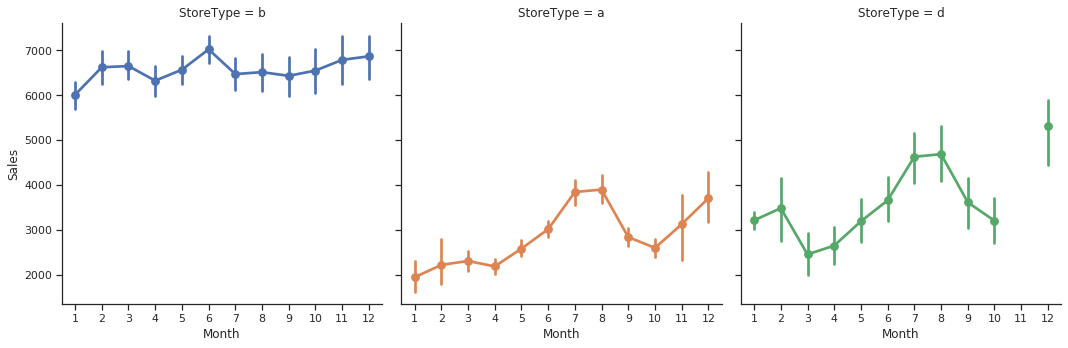

In [278]:
weekend_open = data_train_store[data_train_store.DayOfWeek.isin([6,7])]
sns.factorplot(data = weekend_open, x = 'Month', y = 'Sales', col='StoreType', hue='StoreType')

/home/ns/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


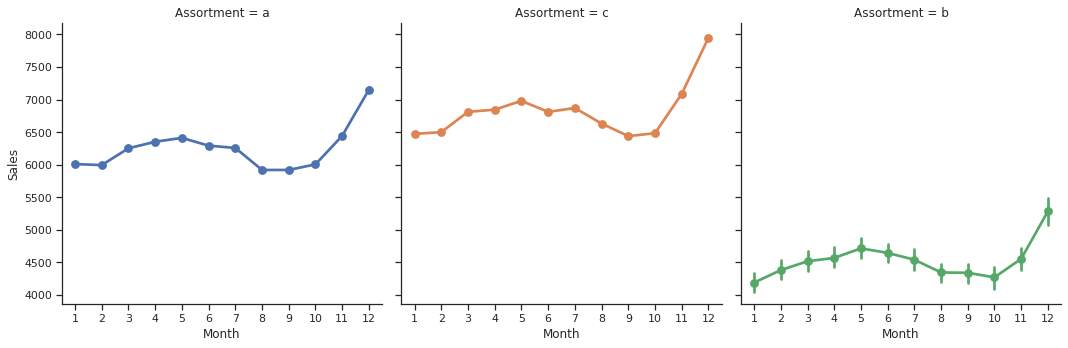

In [279]:
sns.factorplot(data = data_train_store, x = 'Month', y = 'Sales', col='Assortment', hue='Assortment')

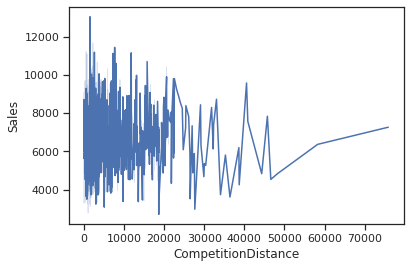

In [291]:
a = data_train_store.groupby('Store').agg({
    'CompetitionDistance': 'mean',
    'Sales': 'mean',
    'Customers': 'mean'
})

sns.lineplot(x = a['CompetitionDistance'], y=a['Sales'])